# Use de Twitter en periódos electorales

## Reporte Preliminar sobre Internas de Diciembre/2017

## Recolección de tweets basada en cuentas (@) y Hashtags (#)

Usando el API de Twitter recoletamos **tweets publicados entre el 27 de Noviembre y el 15 de Enero de 2018**, que provengan de cuentas de pre-candidatos de los principales partidos políticos (ANR y PLRA), y/o contengan hashtags utilizados con fines electorales. Como base utilizamos las cuentas y hashtags publicados por el Diario Última Hora en su artículo [Perfiles de pre-candidatos según las redes](http://elecciones.ultimahora.com/informacion/?id=20), qué luego extendimos en colaboración con [TEDIC](http://tedic.org/). Por ejemplo, Última Hora reporta que el hashtag **#JuntosPodemosMas** es utilizado para identificar tweets vínculados al candidatos Santiago Peña de Honor Colorado. Así mismo, **#MaritoDeLaGente** se utilzan en tweets publicados en favor del candidato del movimiento Colorado Añeteté. Así mismo, el hashtag **#EsAhora** aparece en los tweets relacionados al pre-candidato a la presidencia por el PLRA, Efraín Alegre, mientras que **#VotáLista7** se refiere a la candidatura de Carlos Mateo Balmelli.

[Aquí](https://docs.google.com/spreadsheets/d/e/2PACX-1vQHoukfR9AFhSaz30QHYwKqpwexe1ASrW8ya25Fueh3jXcRPMSjrAyj4SbzryTLiuKkPdi6fsprqtM2/pubhtml) se puede acceder a lista completa de hashtags y cuentas.

## Tamaño del data set

In [1]:
%matplotlib inline

import os
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

os.chdir('..')

from datetime import datetime
from db_manager import *
from data_wrangler import *

plt.style.use('seaborn')

In [17]:
db = DBManager('tweets')
total_tweets = db.search({}, only_relevant_tws=False).count()
print('Se han recolectado {0} tweets y luego almacenados en una base de datos NoSQL (MongoDB) para facilitar su '\
      'análisis'.format(total_tweets))

Se han recolectado 304957 tweets y luego almacenados en una base de datos NoSQL (MongoDB) para facilitar su análisis


## Selección de tweets relevantes

Nos dimos cuenta que los hashtags que usamos para buscar tweets se utilizan también en otros contextos (en otros paises) por lo tanto para los análisis consideramos solo aquellos que además de los hashtags de interés contengan alguna mención a cuentas de los candidatos

In [21]:
te = TweetEvaluator()
te.identify_relevant_tweets()
relevant_tweets = db.search({'relevante': 1}).count()
per_relevant = round(100*(relevant_tweets/total_tweets),0)
print('Seleccionamos {0} tweets que encontramos relevantes para el trabajo ({1}% del total colectado)'.
      format(relevant_tweets, per_relevant))

Seleccionamos 163508 tweets que encontramos relevantes para el trabajo (54.0% del total colectado)


## Evolución de tweets en el tiempo

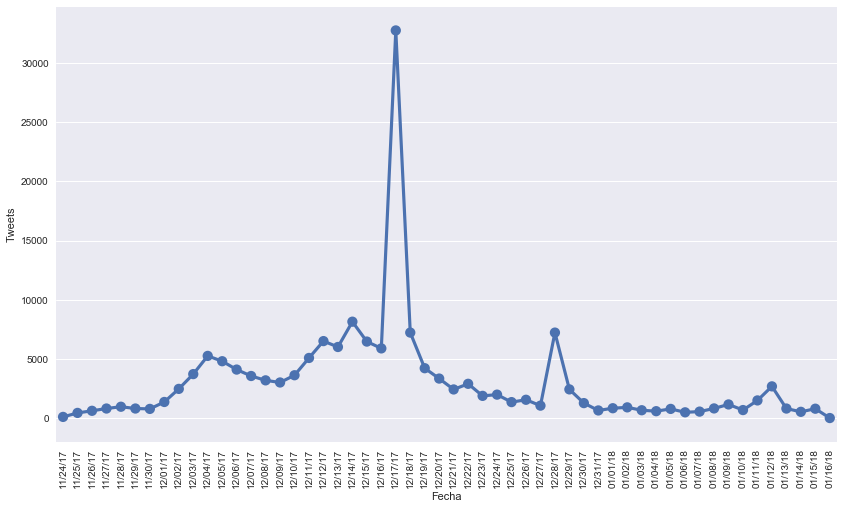

In [26]:
# get tweets by date
plt.figure(figsize=(14,8))
tw_by_date = db.get_tweets_by_date()
# convert list to pandas' dataframe
tweets_por_fecha = pd.DataFrame(tw_by_date)
# draw and show the figure
fig = sns.pointplot(x='_id', y='count', data=tweets_por_fecha)
fig.set(xlabel='Fecha', ylabel='Tweets')
for item in fig.get_xticklabels():
    item.set_rotation(90)
plt.show()

La publicación de tweets fue creciendo con el paso del tiempo. El día de las elecciones (17 de diciembre) se concentró el mayor de publicaciones de tweets, más de 30.000 tweets se publicaron ese día. Pasadas las elecciones los tweets relacionados a las internas decrecieron significativamente con un pequeño pico el día de 28 de diciembre. Este pico pudo haberse debido a que ese día el presidente de la república, Horacio Cartes, confirmó su reunión con Mario Abdo Benítez en busca de la unidad del Partido Colorado ([Cartes confirma abrazo republicano](http://www.abc.com.py/nacionales/cartes-confirma-abrazo-republicano-1662344.html)).

## Tweets por interna

Cada keyword (**`Hashtag`** o **`Cuenta`**) está asociado a uno de los **`partidos políticos`** (*`anr`*, *`plra`*), a uno de los **`movimientos`** en puja (*`honor colorado`*, *`colorado añetete`*, *`progresista colorado`*, *`equipo joven`*), a un candidato (*`santiago peña`*, *`mario abdo`*, *`efrain alegre`*, *`mateo balmelli`*) y a un **`lider de movimiento`** (*`horacio cartes`*, *`mario abdo`*, *`nicanor duarte frutos`*, *`efrain alegre`*,*`blas llano`*). La base de datos fue pre-procesada para marcar cada tweet con estos datos. En el caso de Efrain, su candidatura no está asociado a un movimiento particular, pero lo tomamos en cuenta como lidere del conglomerado de movimientos que apoyaron su campaña. 

In [4]:
tweets_plra = db.search({'partido_politico': 'plra'})
tweets_anr = db.search({'partido_politico': 'anr'})
print('Tweets relacionados a la interna ANR: {0}'.format(tweets_anr.count()))
print('Tweets relacionados a la interna PLRA: {0}'.format(tweets_plra.count()))


Tweets relacionados a la interna ANR: 187676
Tweets relacionados a la interna PLRA: 8731


In [5]:
tweets_indep = db.search( {"$and": [ {'partido_politico':  { "$ne": 'anr' }}, {'partido_politico':  { "$ne": 'plra' }}]})
print('Tweets relacionados a ninguna interna: {0}'.format(tweets_indep.count()))

Tweets relacionados a ninguna interna: 14771


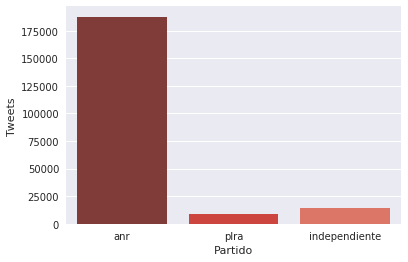

In [19]:
tweets_por_interna = pd.DataFrame({
    'Partido': ['anr', 'plra', 'independiente'],
    'Tweets': [tweets_anr.count(), tweets_plra.count(), tweets_indep.count()]
}, index=['anr', 'plra', 'independiente'])
sns.barplot(x='Partido', y='Tweets', data=tweets_por_interna, palette="Reds_d")


Es importante notar que el número de keywords que monitoreamos para la `anr` era 4 veces mayor a los keywords del `plra` (28 a 7). Esto puede explicar en parte la diferencia en volumen. Al mismo tiempo, no existían otros keywords populares, utilizados en las internas del plra, más allá de los que monitoreamos. 

## Distribución de tweets por candidato

Para este análisis solo se tuvieron en cuenta los tweets que contienen hashtags orientadas principalmente a promocionar la figura del **candidato**, no del **movimiento** o **partido** al que este pertenece. Por ejemplo, los hashtags **#JuntosPodemosMas** o **#CaminandoJuntos** son hashtags vinculados principalmente a la figura de Santiago Peña no así el hashtag **#HonorColorado** que se utiliza para promocionar el movimiento partidario pero no necesariamente la candidatura de Peña. Aquí consideramos solo los primeros, es decir, aquellos vinculados directamente al candidato.

* Hashtags relacionados directamente con la campaña de Peña y que se consideraron para este análisis: `#SantiPresidente`, `#VotoxSanti`, `#SigamosConversando`

* Hashtags relacionados directamente con la campaña de Abdo y que se consideraron para este análisis: `#MaritoDeLaGente`, `#ParaguayDeLaGente`

* Hashtags relacionados directamente con la campaña de Efrain y que se consideraron para este análisis: 
`#EsAhora`, `#VamosAGanarTodos`

* Hashtags relacionados directamente con la campaña de Balmelli y que se consideraron para este análisis: 
`#VotáLista7`, `#CarlosMateoPresidente`

En los siguientes análisis no se tendrán en cuenta los tweets publicados por los candidatos personalmente.

### Santiago Peña

`#SantiPresidente`, `#VotoxSanti`, `#SigamosConversando`

In [8]:
q_sp = {'candidatura': 'santiago peña', 'tweet_obj.user.screen_name': {'$eq':'SantiPenap'}}
tweets_sp = db.search(q_sp)
print('Tweets de Santiago Peña: {0}'.format(tweets_sp.count()))

Tweets de Santiago Peña: 142


In [9]:
q_mov_hc = {'movimiento': 'honor colorado', 'tweet_obj.user.screen_name': {'$ne':'SantiPenap'}}
tweets_mov_hc = db.search(q_mov_hc)
print('Tweets del movimiento Honor Colorado: {0}'.format(tweets_mov_hc.count()))

Tweets del movimiento Honor Colorado: 124362


In [10]:
q_nsp = {'candidatura': 'santiago peña', 'tweet_obj.user.screen_name': {'$ne':'SantiPenap'}}
tweets_sp = db.search(q_nsp)
print('Tweets relacionados al candidato Santiago Peña: ' \
      '{0} ({1}% del total del movimiento HC)'.format(tweets_sp.count(), 
                                                      round((tweets_sp.count()/tweets_mov_hc.count())*100,2)))

Tweets relacionados al candidato Santiago Peña: 59549 (47.88% del total del movimiento HC)


### Mario Abdo Benítez

`#MaritoDeLaGente`, `#ParaguayDeLaGente`

In [11]:
q_ma = {'candidatura': 'mario abdo', 'tweet_obj.user.screen_name': {'$eq':'MaritoAbdo'}}
tweets_ma = db.search(q_ma)
print('Tweets de Mario Abdo: {0}'.format(tweets_ma.count()))

Tweets de Mario Abdo: 230


In [12]:
q_mov_ca = {'movimiento': 'colorado añetete', 'tweet_obj.user.screen_name': {'$ne':'MaritoAbdo'}}
tweets_mov_ca = db.search(q_mov_ca)
print('Tweets del movimiento Colorado Añetete: {0}'.format(tweets_mov_ca.count()))

Tweets del movimiento Colorado Añetete: 60411


In [13]:
q_nma = {'candidatura': 'mario abdo', 'tweet_obj.user.screen_name': {'$ne':'MaritoAbdo'}}
tweets_ma = db.search(q_nma)
print('Tweets relacionados al candidato Mario Abdo: ' \
      '{0} ({1}% del total del movimiento Colorado Añeteté)'.format(tweets_ma.count(), 
                                                      round((tweets_ma.count()/tweets_mov_ca.count())*100,2)))

Tweets relacionados al candidato Mario Abdo: 44741 (74.06% del total del movimiento Colorado Añeteté)


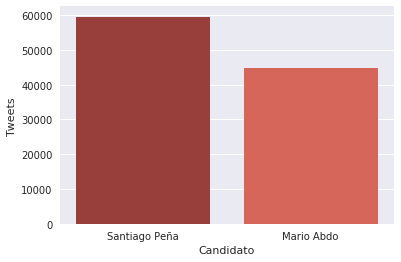

In [14]:
tweets_por_candidato_anr = pd.DataFrame({
    'Candidato': ['Santiago Peña', 'Mario Abdo'],
    'Tweets': [tweets_sp.count(),tweets_ma.count()]
}, index=['sp', 'ma'])
sns.barplot(x='Candidato', y='Tweets', data=tweets_por_candidato_anr, palette="Reds_d")

### Efraín Alegre

`#EsAhora`, `#VamosAGanarTodos`

In [46]:
q_ea = {'$or':[{'candidatura':'efrain alegre'},{'candidatura':'efrain alegre\n'}], 'tweet_obj.user.screen_name': {'$eq':'EfrainAlegre'}}
tweets_ea = db.search(q_ea)
print('Tweets de Efrain Alegre: {0}'.format(tweets_ea.count()))

Tweets de Efrain Alegre: 30


In [44]:
q_mov_ea = {'$or':[{'candidatura':'efrain alegre'},{'candidatura':'efrain alegre\n'}], 'tweet_obj.user.screen_name': {'$ne':'EfrainAlegre'}}
tweets_mov_ea = db.search(q_mov_ea)
print('Tweets de la candidatura de Efraín Alegre: {0}'.format(tweets_mov_ea.count()))

Tweets de la candidatura de Efraín Alegre: 6869


### Mateo Balmelli

`#VotáLista7`, `#CarlosMateoPresidente`

In [47]:
q_mb = {'$or': [{'candidatura': 'carlos mateo balmelli'},{'candidatura': 'carlos mateo balmelli\n'}], 'tweet_obj.user.screen_name': {'$eq':'CARLOSMATEOPY'}}
tweets_mb = db.search(q_mb)
print('Tweets de Carlos Mateo Balmelli: {0}'.format(tweets_mb.count()))

Tweets de Carlos Mateo Balmelli: 181


In [48]:
q_mov_ej = {'candidatura': 'carlos mateo balmelli', 'tweet_obj.user.screen_name': {'$ne':'CARLOSMATEOPY'}}
tweets_mov_mb = db.search(q_mov_ej)
print('Tweets de la candidatura de Carlos Mateo Balmelli: {0}'.format(tweets_mov_mb.count()))

Tweets de la candidatura de Carlos Mateo Balmelli: 1041


A diferencia de la ANR, solo recolectamos tweets directamente asociados a los candidatos, ya que no existían keywords populares relacionados con movimientos internos. 

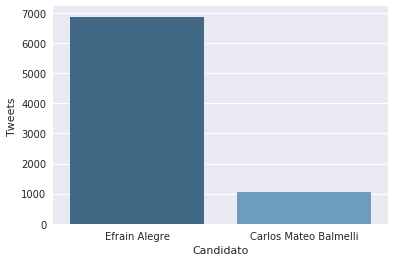

In [49]:
tweets_por_candidato_plra = pd.DataFrame({
    'Candidato': ['Efrain Alegre', 'Carlos Mateo Balmelli'],
    'Tweets': [tweets_mov_ea.count(),tweets_mov_mb.count()]
}, index=['ea', 'mb'])
sns.barplot(x='Candidato', y='Tweets', data=tweets_por_candidato_plra, palette="Blues_d")

## Hashtags más populares usados por los candidatos

### Santiago Peña

In [6]:
additional_args = {'include_candidate':False, 'candidate_handler':'SantiPenap'}
hashtags_hc = db.get_hashtags_by_candidate('santiago peña', **additional_args)
hashtags_populares_hc = []
sum_total = 0
for i in range(5):
    hashtag = hashtags_hc[i]
    sum_total += hashtag['count']
    hashtag_dict = {'1. Hashtag': '#' + hashtag['_id'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_hc.append(hashtag_dict)
pd.DataFrame(hashtags_populares_hc)

,1. Hashtag,2. Cantidad de Tweets
0,#SantiPresidente,8058
1,#VotoxSanti,4003
2,#SigamosConversando,1588
3,#HonorColorado,929
4,#Lista2,694


### Mario Abdo

In [5]:
additional_args = {'include_candidate':False, 'candidate_handler':'MaritoAbdo'}
hashtags_ca = db.get_hashtags_by_candidate('mario abdo', **additional_args)
hashtags_populares_ca = []
for i in range(5):
    hashtag = hashtags_ca[i]
    hashtag_dict = {'1. Hashtag': '#' + hashtag['_id'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_ca.append(hashtag_dict)
pd.DataFrame(hashtags_populares_ca)

,1. Hashtag,2. Cantidad de Tweets
0,#ParaguayDeLaGente,10578
1,#MaritoDeLaGente,2014
2,#Lista3,737
3,#ColoradoAñetete,489
4,#MaritoPresidente,358


### Efraín Alegre

In [50]:
additional_args = {'include_candidate':False, 'candidate_handler':'EfrainAlegre'}
hashtags_ea_1 = db.get_hashtags_by_candidate('efrain alegre', **additional_args)
hashtags_ea_2 = db.get_hashtags_by_candidate('efrain alegre\n', **additional_args)
hashtags_populares_ea = []
hashtag_dict_by_keyword = {}
for i in range(2):
    hashtag = hashtags_ea_1[i]
    key = hashtag['_id'];
    hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}
    
for i in range(2):
    hashtag = hashtags_ea_2[i]
    key = hashtag['_id'];
    if key in hashtag_dict_by_keyword:
        current_count = hashtag_dict_by_keyword[key]['count']
        hashtag_dict_by_keyword[key] = {'key': key, 'count': current_count+hashtag['count']}
    else:
        hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}

for key in hashtag_dict_by_keyword:
    hashtag = hashtag_dict_by_keyword[key]
    hashtag_dict = {'1. Hashtag': '#' + hashtag['key'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_ea.append(hashtag_dict)
    
pd.DataFrame(hashtags_populares_ea)

,1. Hashtag,2. Cantidad de Tweets
0,#VamosAGanarTodos,8
1,#InternasPLRA,2
2,#EsAhora,211


### Carlos Mateo Balmelli 

In [54]:
additional_args = {'include_candidate':False, 'candidate_handler':'CARLOSMATEOPY'}
hashtags_ea_1 = db.get_hashtags_by_candidate('carlos mateo balmelli', **additional_args)
hashtags_ea_2 = db.get_hashtags_by_candidate('carlos mateo balmelli\n', **additional_args)
hashtags_populares_ea = []
hashtag_dict_by_keyword = {}
for i in range(1):
    hashtag = hashtags_ea_1[i]
    key = hashtag['_id'];
    hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}
    
for i in range(1):
    hashtag = hashtags_ea_2[i]
    key = hashtag['_id'];
    if key in hashtag_dict_by_keyword:
        current_count = hashtag_dict_by_keyword[key]['count']
        hashtag_dict_by_keyword[key] = {'key': key, 'count': current_count+hashtag['count']}
    else:
        hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}

for key in hashtag_dict_by_keyword:
    hashtag = hashtag_dict_by_keyword[key]
    hashtag_dict = {'1. Hashtag': '#' + hashtag['key'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_ea.append(hashtag_dict)
    
pd.DataFrame(hashtags_populares_ea)

,1. Hashtag,2. Cantidad de Tweets
0,#VotáLista7,392


## Cantidad de tuiteros por movimiento

### Honor Colorado

In [8]:
additional_args = {'include_candidate':False, 'candidate_handler':'SantiPenap', 'movimiento':'honor colorado'}
unique_users_hc = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Honor Colorado'.format(len(unique_users_hc)))

20505 usuarios tuitearon sobre Honor Colorado


#### Top-10 más activos con sus actividades

In [9]:
top10_tuiteros_hc = []
for i in range(10):
    tuitero_hc = {'1.Usuario': unique_users_hc[i]['screen_name'], 
                  '2.Tweets': unique_users_hc[i]['tweets_count'],
                  '3.Originales': unique_users_hc[i]['original_count'],
                  '4.Retweets': unique_users_hc[i]['retweets_count'],
                  '5.Quotes': unique_users_hc[i]['quotes_count'],
                  '6.Replies': unique_users_hc[i]['replies_count'],
                  '7.Followers': unique_users_hc[i]['followers'],
                  '8.Friends': unique_users_hc[i]['friends']}
    top10_tuiteros_hc.append(tuitero_hc)
pd.DataFrame(top10_tuiteros_hc)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,CESARSANCHEZ553,869,0,589,0,280,17,132
1,ArturoO22734057,822,1,816,0,5,192,825
2,Michelec1954,809,0,0,674,135,708,1484
3,Norabeli,756,0,565,2,189,1387,930
4,delgapy2016,732,0,703,0,29,79,461
5,CesarSanchez636,538,0,399,0,139,155,651
6,Mariade84654356,536,0,536,0,0,12,80
7,machaparro48,525,0,380,0,145,928,886
8,gladysgulino,489,0,489,0,0,471,93
9,AngelicaZunilda,489,0,232,0,257,124,50


### Colorado Añeteté

In [10]:
additional_args = {'include_candidate':False, 'candidate_handler':'MaritoAbdo', 'movimiento':'colorado añetete'}
unique_users_ca = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Colorado Anetete'.format(len(unique_users_ca)))

10047 usuarios tuitearon sobre Colorado Anetete


#### Top-10 más activos y sus actividades

In [11]:
top10_tuiteros_ca = []
for i in range(10):
    tuitero_ca = {'1.Usuario': unique_users_ca[i]['screen_name'], 
                  '2.Tweets': unique_users_ca[i]['tweets_count'],
                  '3.Originales': unique_users_ca[i]['original_count'],
                  '4.Retweets': unique_users_ca[i]['retweets_count'],
                  '5.Quotes': unique_users_ca[i]['quotes_count'],
                  '6.Replies': unique_users_ca[i]['replies_count'],
                  '7.Followers': unique_users_ca[i]['followers'],
                  '8.Friends': unique_users_ca[i]['friends']}
    top10_tuiteros_ca.append(tuitero_ca)
pd.DataFrame(top10_tuiteros_ca)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,Paraguaynosune,1332,0,1332,0,0,520,174
1,Solmelga,690,208,413,1,68,5323,4790
2,Beatriz20D,669,0,612,0,57,210,739
3,jjrios_bogado,447,54,391,0,2,1870,777
4,EDITHVILLA3,427,11,324,0,92,598,1117
5,grfzp7771,408,4,342,0,62,39,369
6,felixugarte,403,0,399,0,4,499,369
7,Rogerlopez1980,363,0,357,0,6,93,375
8,LaJusticierra,349,2,336,0,11,3344,1262
9,EmanoelQuiroga,339,56,281,0,2,33,134


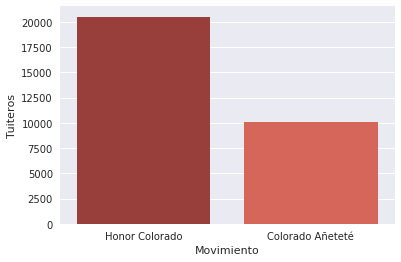

In [12]:
tuiteros_por_movimiento = pd.DataFrame({
    'Movimiento': ['Honor Colorado', 'Colorado Añeteté'],
    'Tuiteros': [len(unique_users_hc), len(unique_users_ca)]
}, index=['hc', 'ca'])
sns.barplot(x='Movimiento', y='Tuiteros', data=tuiteros_por_movimiento, palette="Reds_d")

Como se podría esperar el ejercito de tuiteros del movimiento *Honor Colorado* es ampliamente superior al de *Colorado Añeteté*. Prácticamente, **por cada tuitero de *Colorado Añeteté* existen casi 2.5 tuiteros de *Honor Colorado***. La diferencia en la cantidad de tuiteros se puede percibir también en la cantidad de tweets de cada movimiento; Honor Colorado tiene casi el doble de tweets que Colorado Añeteté.

Otro aspecto destacable del último análisis es el tipo de actividad que realizan tanto los tuiteros de *Honor Colorado* como los de *Añeteté*. En ambos casos, **los tuiteros más activos no publican nuevo tweets** sino se limitan a casi exclusivamente a retuitear tweets vinculados a su movimiento. En otras palabras, la principal actividad de estos usuarios es amplificar y promocionar información relacionada a sus intereses. **Este comportamiento es típico de bots y cuentas falsas**. La siguiente tarea en el estudio consistirá, por lo tanto, en análizar más en detalle el comportamiento de estas cuentas con el objetivo de verificar si son falsas o se encuentran vínculadas a sistemas automáticos de publicaciones. 

## Cantidad de tuiteros por candidatura

### Santiago Peña

In [13]:
additional_args = {'include_candidate':False, 'candidate_handler':'SantiPenap', 'candidatura':'santiago peña'}
unique_users_sp = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Santiago Peña'.format(len(unique_users_sp)))

14917 usuarios tuitearon sobre Santiago Peña


#### Top-10 más activos con sus actividades

In [15]:
top10_tuiteros_sp = []
for i in range(10):
    tuitero_sp = {'1.Usuario': unique_users_sp[i]['screen_name'], 
                  '2.Tweets': unique_users_sp[i]['tweets_count'],
                  '3.Originales': unique_users_sp[i]['original_count'],
                  '4.Retweets': unique_users_sp[i]['retweets_count'],
                  '5.Quotes': unique_users_sp[i]['quotes_count'],
                  '6.Replies': unique_users_sp[i]['replies_count'],
                  '7.Followers': unique_users_sp[i]['followers'],
                  '8.Friends': unique_users_sp[i]['friends']}
    top10_tuiteros_sp.append(tuitero_sp)
pd.DataFrame(top10_tuiteros_sp)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,CESARSANCHEZ553,482,0,343,0,139,20,147
1,SemideiOmar,383,8,1,0,374,421,284
2,CesarSanchez636,360,0,257,0,103,155,651
3,Norabeli,349,0,252,0,97,1390,933
4,ArturoO22734057,345,1,341,0,3,196,833
5,delgapy2016,269,0,258,0,11,82,462
6,Radio970AM,240,26,3,1,210,212055,878
7,guidoschultz73,223,0,184,0,39,175,259
8,machaparro48,209,0,137,0,72,929,886
9,AngelicaZunilda,201,0,82,0,119,132,50


### Mario Abdo

In [16]:
additional_args = {'include_candidate':False, 'candidate_handler':'MaritoAbdo', 'candidatura':'mario abdo'}
unique_users_ma = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Mario Abdo'.format(len(unique_users_ma)))

9834 usuarios tuitearon sobre Mario Abdo


#### Top-10 más activos y sus actividades

In [17]:
top10_tuiteros_ma = []
for i in range(10):
    tuitero_ma = {'1.Usuario': unique_users_ma[i]['screen_name'], 
                  '2.Tweets': unique_users_ma[i]['tweets_count'],
                  '3.Originales': unique_users_ma[i]['original_count'],
                  '4.Retweets': unique_users_ma[i]['retweets_count'],
                  '5.Quotes': unique_users_ma[i]['quotes_count'],
                  '6.Replies': unique_users_ma[i]['replies_count'],
                  '7.Followers': unique_users_ma[i]['followers'],
                  '8.Friends': unique_users_ma[i]['friends']}
    top10_tuiteros_ma.append(tuitero_ma)
pd.DataFrame(top10_tuiteros_ma)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,Paraguaynosune,739,0,739,0,0,521,175
1,Beatriz20D,498,0,449,0,49,209,738
2,Solmelga,429,119,255,1,54,5345,4793
3,felixugarte,251,0,247,0,4,502,369
4,Norabeli,235,1,189,1,44,1390,933
5,jjrios_bogado,232,26,204,0,2,1871,780
6,CESARSANCHEZ553,214,0,204,0,10,20,147
7,EDITHVILLA3,212,4,167,0,41,599,1117
8,EmanoelQuiroga,209,38,170,0,1,33,134
9,Rogerlopez1980,196,0,193,0,3,93,376


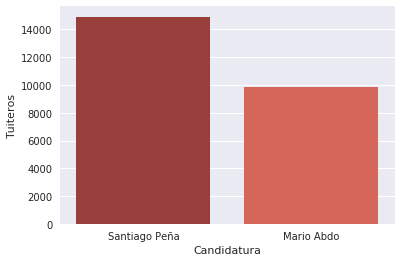

In [22]:
tuiteros_por_candidatura_anr = pd.DataFrame({
    'Candidatura': ['Santiago Peña', 'Mario Abdo'],
    'Tuiteros': [len(unique_users_sp), len(unique_users_ma)]
}, index=['sp', 'ma'])
sns.barplot(x='Candidatura', y='Tuiteros', data=tuiteros_por_candidatura_anr, palette="Reds_d")

### Efrain Alegre

In [5]:
additional_args = {'include_candidate':False, 'candidate_handler':'EfrainAlegre', 'candidatura':'efrain alegre'}
unique_users_ea_1 = db.get_unique_users(**additional_args)
additional_args = {'include_candidate':False, 'candidate_handler':'EfrainAlegre', 'candidatura':'efrain alegre\n'}
unique_users_ea_2 = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Efrain Alegre'.format(len(unique_users_ea_1)+len(unique_users_ea_2)))

3004 usuarios tuitearon sobre Efrain Alegre


#### Top-10 más activos y sus actividades

In [7]:
top10_tuiteros_ea = []
# ToDo: merge lists or clean database
unique_users_ea = unique_users_ea_1
for i in range(10):
    tuitero_ea = {'1.Usuario': unique_users_ea[i]['screen_name'], 
                  '2.Tweets': unique_users_ea[i]['tweets_count'],
                  '3.Originales': unique_users_ea[i]['original_count'],
                  '4.Retweets': unique_users_ea[i]['retweets_count'],
                  '5.Quotes': unique_users_ea[i]['quotes_count'],
                  '6.Replies': unique_users_ea[i]['replies_count'],
                  '7.Followers': unique_users_ea[i]['followers'],
                  '8.Friends': unique_users_ea[i]['friends']}
    top10_tuiteros_ea.append(tuitero_ea)
pd.DataFrame(top10_tuiteros_ea)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,algoandamalpy,90,89,0,0,1,71674,524
1,c10arguello,47,0,35,0,12,587,3133
2,alebogado7902,46,0,14,0,32,2199,2166
3,LaUnionAM800,43,41,2,0,0,42560,280
4,fran_rat,39,1,11,3,24,517,657
5,desimasi2,37,6,8,5,18,27285,400
6,CesarSanchez636,36,0,33,0,3,156,651
7,JacquiSachelar1,36,1,19,4,12,279,343
8,ABCCardinal,35,35,0,0,0,183553,890
9,juankilezcano,32,21,8,0,3,7119,4742


### Carlos Mateo Balmelli

In [9]:
additional_args = {'include_candidate':False, 'candidate_handler':'CARLOSMATEOPY', 'candidatura':'carlos mateo balmelli'}
unique_users_mb_1 = db.get_unique_users(**additional_args)
additional_args = {'include_candidate':False, 'candidate_handler':'CARLOSMATEOPY', 'candidatura':'carlos mateo balmelli\n'}
unique_users_mb_2 = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Carlos Mateo Balmelli'.format(len(unique_users_mb_1)+len(unique_users_mb_2)))

685 usuarios tuitearon sobre Carlos Mateo Balmelli


#### Top-10 más activos y sus actividades

In [10]:
top10_tuiteros_mb = []
unique_users_mb = unique_users_mb_1
for i in range(10):
    tuitero_mb = {'1.Usuario': unique_users_mb[i]['screen_name'], 
                  '2.Tweets': unique_users_mb[i]['tweets_count'],
                  '3.Originales': unique_users_mb[i]['original_count'],
                  '4.Retweets': unique_users_mb[i]['retweets_count'],
                  '5.Quotes': unique_users_mb[i]['quotes_count'],
                  '6.Replies': unique_users_mb[i]['replies_count'],
                  '7.Followers': unique_users_mb[i]['followers'],
                  '8.Friends': unique_users_mb[i]['friends']}
    top10_tuiteros_mb.append(tuitero_mb)
pd.DataFrame(top10_tuiteros_mb)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,FSilvaFacetti,91,23,67,0,1,3501,752
1,equipojovenpy,64,3,49,0,12,1454,488
2,AlexOlmedoA,33,0,31,0,2,750,1362
3,luma_careaga,25,0,24,0,1,767,941
4,Radio970AM,23,3,0,0,20,213025,877
5,lanzoni21,16,0,16,0,0,6,76
6,1000_am,15,7,0,0,8,93224,368
7,animelot,13,0,6,0,7,153,383
8,mcsantiliv,12,0,12,0,0,351,312
9,780AM,11,10,1,0,0,291746,1267


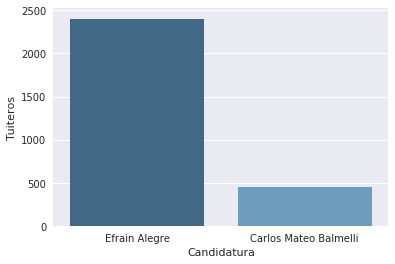

In [12]:
tuiteros_por_candidatura_plra = pd.DataFrame({
    'Candidatura': ['Efrain Alegre', 'Carlos Mateo Balmelli'],
    'Tuiteros': [len(unique_users_ea), len(unique_users_mb)]
}, index=['ea', 'mb'])
sns.barplot(x='Candidatura', y='Tuiteros', data=tuiteros_por_candidatura_plra, palette="Blues_d")

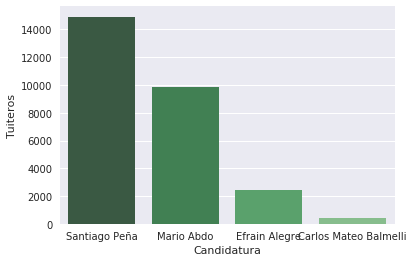

In [25]:
tuiteros_por_candidatura = pd.DataFrame({
    'Candidatura': ['Santiago Peña', 'Mario Abdo', 'Efrain Alegre', 'Carlos Mateo Balmelli'],
    'Tuiteros': [len(unique_users_sp), len(unique_users_ma),len(unique_users_ea), len(unique_users_mb)]
}, index=['sp','ma','ea', 'mb'])
sns.barplot(x='Candidatura', y='Tuiteros', data=tuiteros_por_candidatura, palette="Greens_d")